In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import pdb
import time
from PIL import Image

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict

# Set Hyperparameters

In [2]:
tr_batchsize = 32
eval_test_batchsize = 16
epochs = 10
lr = 0.001

Set the device checking & setting

In [3]:
# By defalt, set device to the CPU
deviceFlag = torch.device('cpu')

# Defalut is CPU, but as long as GPU is avaliable, then use GPU
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPUs.')
    deviceFlag = torch.device('cuda:0') # Manually pick your cuda device. By default is 'cuda:0'

print(f'Now the deivce is set to {deviceFlag}')

Found 4 GPUs.
Now the deivce is set to cuda:0


# @ The Validation Function

In [4]:
def validation(model, validateloader, ValCriterion):
    
    val_loss_running = 0
    acc = 0
    
    # a dataloader object is a generator of batches, each batch contain image & label separately
    for images, labels in iter(validateloader):
        
        # Send the data onto choosen device
        images = images.to(deviceFlag)
        labels = labels.to(deviceFlag)
        
        output = model.forward(images)
        val_loss_running += ValCriterion(output, labels).item() # .item() to get a scalar in Torch.tensor out
        
        output = torch.exp(output) # as in the model we use the .LogSoftmax() output layer
        
        equals = (labels.data == output.max(dim = 1)[1])
        acc += equals.float().mean().item() # .flaot() is to transfer the tensor.cuda.float type onto cpu mode
        
    return val_loss_running / len(validateloader), acc / len(validateloader)

# @ The Training (&Validating) Function

In [5]:
def train_eval(model, traindataloader, validateloader, TrCriterion, optimizer, epochs, deviceFlag_train):
    
    itrs = 0
    eval_itrs = 40
    
    # first setting the device used for training
    model.to(deviceFlag_train)
    
    print(f'The training batchsize is {tr_batchsize}.')
    
    # set the timer
    since = time.time()

    # ! THE EPOCH LOOP !
    for e in range(epochs):        
        itrs = 0
        
        # Set the model to the Train mode
        # Tell the model to activate its Training behavior (turn-on the dropout & BN behaviors)
        model.train()
        
        # re-initialize the running_loss to start every epoch
        training_loss_running = 0
        
        #  ! THE BATCH LOOP !
        for inputs, labels in iter(traindataloader):            
            itrs += 1
            # .to() method return a copy of the tensors on the targeted device
            inputs = inputs.to(deviceFlag_train)
            labels = labels.to(deviceFlag_train)
            
            # Clean the stored grads computed in the last iteration
            optimizer.zero_grad()
            
            # Forward Pass
            # As model has been shipped to the targeted device, so the output is on that device too
            outputs = model.forward(inputs)
            
            # Compute Loss
            train_loss = TrCriterion(outputs, labels)
            
            # BackProp to compute the grads (stored in each tensor.grad() attributes) along the way
            train_loss.backward()
            
            # Optimizer/Update params
            optimizer.step()
            
            training_loss_running += train_loss.item() #numeric ops, take the scalar out of the tensor by calling .item()
            
            # ----------- Perform Validation (Evaluation) Every eval_itrs iterations ---------- #
            if itrs % eval_itrs == 0:
                
                # Set the model to the Eval mode
                model.eval()
                
                # Turn-off gradient for validation to save memory & computation
                with torch.no_grad():
                    validation_loss, val_acc = validation(model, validateloader, TrCriterion)
                
                display = f'Epoch: {e + 1}/{epochs}, itrs: {itrs}, '
                display += f'Train_loss: {round(training_loss_running / eval_itrs, 4)}, '
                display += f'Valid_loss: {round(validation_loss, 4)}, '
                display += f'Valid_Acc: {round(val_acc, 4)}'
                print(display)
                
                training_loss_running = 0
                model.train()
                
        end = time.time()
        elapsed = end - since
        print(f'Epoch {e + 1} takes {round(elapsed, 4)} sec')

# @ The TEST function

In [6]:
def test_acc(model, testloader, deviceFlag_test):

    # for testing, it is actually do validation on the test set
    model.eval()

    model.to(deviceFlag_test)

    since = time.time()

    # In .eval() mode, set the context manager to turn-off grads
    with torch.no_grad():
        acc = 0

        # iter() gives images and labels in batches
        for inputs, labels in iter(test_loader):
            
            inputs = inputs.to(deviceFlag_test)
            labels = labels.to(deviceFlag_test)

            # Do a forward pass
            output = model.forward(inputs)
            # convert the log likelihood to scalar
            prob = torch.exp(output)

            equals = (labels.data == prob.max(dim = 1)[1])

            acc += equals.type(torch.FloatTensor).mean().item()

        end = time.time()
        elapsed = end - since

        print(f'Test_acc: {round(acc, 4)}, tiem_spent: {round(elapsed, 2)} sec')

# @ The Chkpt saving function
A chkpt is a dictionary.
save as much info you need for loading and testing.
If want to load then keep on trianing with where it left off, remmeber to save the optimizer.state_dict too

In [7]:
def save_checkpoint(model, optimizer, trainingdataset, saved_pth):
    # set a new attr to the model object, which holds the class_to_idx conversion
    model.class_to_idx = trainingdataset.class_to_idx
    
    # Chkpt is a dictionary, can be modified to hold anything you need in the furture
    chkpt = {
    'arch': 'vgg19',
    'class_to_idx': model.class_to_idx,
    'model_state_dict': model.state_dict(),
   # 'optimizer_state_dict': optimizer.state_dict()
    }
    
    # Save with torch.save
    torch.save(chkpt, saved_pth)

# @ The Chkpt Loading function
Need to re-initialzie (re-build in the same way as the model is built before training it) a new model with the same arch as stored in the chkpt, then load the .stat_dict() params into this new arch

In [8]:
def load_checkpoint(chkpt_path):
    
    chkpt = torch.load(chkpt_path)
    
    # After loading, the elements stored in the chkpt can be accesses as in a dict with key & value
    if chkpt['arch'] == 'vgg19':
        # Re-initial a new network arch
        model = models.vgg19(pretrained = True)
        
        # Turn-off the .requires_grad attributes for all params in the feature extraction head
        for params in model.parameters():
            params.requires_grad = False
    
    else:
        print('------- Wrong Network Architecture is being used----------')
    
    model.class_to_idx = chkpt['class_to_idx']
    
    # Re-inital a new empty classisifer
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p = 0.5)),
        ('fc2', nn.Linear(4096, 102)),
        ('output', nn.LogSoftmax(dim = 1))
    ]))
    
    # Attach the classifer head
    model.classifier = classifier
    
    # Load the params stored in the chkpt into the newly constructed empty model
    # model.load_state_dict() is a built-in method of the models object
    model.load_state_dict(chkpt['model_state_dict'])
    
    return model

# @ Image PreProcessing Function
Using the PIL Image module
1. Resize image while keeping aspect ratio: thumbnail() or resize();
2. Crop the image into the required size;
3. Normalizing (<font color = 'red'>convert PIL image object to np.array: np_image = np.array(PIL_image))</font>
4. Switch the array axes from <font color = 'red'>[H, W, C] (np.array & PIL image)  to  [C, H, W]  (PT tensor) </font> using ndarray.transpose

In [9]:
def image_preprocessing(img_pth):
    '''
    Input a PIL image, output a numpy array with axes transposed to [Ch, H, W]
    '''
    pil_image = Image.open(img_pth)
    
    # -------- Resize with Aspect Ratio maintained--------- #
    # First fixing the short axes
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((10000000, 256))
    else:
        pil_image.thumbnail((256, 100000000))
    
    # ---------Crop----------- #
    left_margin = (pil_image.width - 224) / 2
    bottom_margin = (pil_image.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # --------- Convert to np then Normalize ----------- #
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image -mean) / std
    
    # --------- Transpose to fit PyTorch Axes ----------#
    np_image = np_image.transpose([2, 0, 1])
    
    return np_image

# @ Image Dispalying Function with Matplotlib

In [10]:
def imshow(pt_image, ax = None, title = None):
    '''
    Takes in a PyTorch-compatible image with [Ch, H, W],
    Convert it back to [H, W, Ch], 
    Undo the preprocessing,
    then display it on a grid
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    # --------- Transpose ----------- #
    plt_image = pt_image.transpose((1, 2, 0))
    
    # --------- Undo the preprocessing --------- #
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt_image = plt_image * std + mean
    
    if title is not None:
        ax.set_title(title)
        
    # Image need to be clipped between 0 and 1 or it looks noisy
    plt_image = np.clip(plt_image, 0, 1)
    
    # this imshow is a function defined in the plt module
    ax.imshow(plt_image)
    
    return ax

# @ Prediction Function
1. input a path to a img, preprocess it with image_preprocessing()
2. forward pass on a model
3. use tensor.topk(k) to return the highest k probs and the correspodniung class idx
4. convert the idx to class names using the name_to_idx conversion

In [11]:
def predict(img_pth, model, trainingdataset, topk):
    '''
    1. input a single img;
    2. forward pass on a model;
    3. use tensor.topk(k) to return the highest k probs and the correspodniung class idx;
    4. convert the idx to class names using the name_to_idx conversion.
    '''
    np_img = image_preprocessing(img_pth)
    
    # Convert np_img to PT tensor and send to GPU
    pt_img = torch.from_numpy(np_img).type(torch.cuda.FloatTensor)
    
    # Unsqueeze to get shape of tensor from [Ch, H, W] to [Batch, Ch, H, W]
    pt_img = pt_img.unsqueeze(0)

    # Run the model to predict
    output = model.forward(pt_img)
    
    probs = torch.exp(output)
    
    # Pick out the topk from all classes 
    top_probs, top_indices = probs.topk(topk)
    
    # Convert to list on CPU without grads
    top_probs = top_probs.detach().type(torch.FloatTensor).numpy().tolist()[0]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0]
    
    # Invert the class_to_idx dict to a idx_to_class dict
    idx_to_class = {value: key for key, value in trainingdataset.class_to_idx.items()}
    
    top_classname = {idx_to_class[index] for index in top_indices}
    
    return top_probs, top_classname    

# DATA LOADING
here the 102 flowers dataset is pre-downloaded at local, so no need to call the torchvision.datasets.CIFAR10() etc.

In [12]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# DATA AUGMENTATION

In [13]:
training_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # For GPU purpose
    # As we are going to do transfer learning with a ImageNet pretrained VGG
    # so here we normalize the dataset being used here with the ImageNet stats
    # for better transfer learning performance
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

testing_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

# Load the datasets with torchvision.datasets.ImageFolder object
training_imagefolder = datasets.ImageFolder(train_dir, transform = training_transforms)
validation_imagefolder = datasets.ImageFolder(valid_dir, transform = validation_transforms)
testing_imagefolder = datasets.ImageFolder(test_dir, transform = testing_transforms)

# Define the torch.utils.data.DataLoader() object with the ImageFolder object
# Dataloader is a generator to read from ImageFolder and generate them into batch-by-batch
# Only shuffle during trianing, validation and testing no shuffles
# the batchsize for training and tesitng no need to be the same
train_loader = torch.utils.data.DataLoader(training_imagefolder, batch_size = tr_batchsize, shuffle = True)
validate_loader = torch.utils.data.DataLoader(validation_imagefolder, batch_size = eval_test_batchsize)
test_loader = torch.utils.data.DataLoader(testing_imagefolder, batch_size = eval_test_batchsize)

# Classes name to class index number Mapping with JSON

In [14]:
import json
with open('flower_to_name.json', 'r') as f:
    flower_to_name = json.load(f)

#print(len(flower_to_name))
#print(flower_to_name)

# GET pretrained VGG with a new classifier head

In [15]:
model = models.vgg19(pretrained = True)

Freeze the params in the feature head, by setting .requries.grad to False

In [16]:
for params in model.parameters():
    params.requries_grad = False

Build a customed classifier head with 102 output classes

In [17]:
NewClassifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu', nn.ReLU()),
    ('drop', nn.Dropout(p = 0.5)),
    ('fc2', nn.Linear(4096, 102)),
    ('output', nn.LogSoftmax(dim = 1))
]))

Attach the new classifier head onto the model

In [18]:
model.classifier = NewClassifier

# Define the loss func and the optimizer

In [19]:
# Negative Log Likelihood Loss
criterion = nn.NLLLoss()
# in the optimzier, define the range of params to be updated
# Here we only train the params in the model.classifier part (model object has the classifier attribute)
optimizer = optim.Adam(model.classifier.parameters(), lr = lr)

# Train & Eval the model

In [20]:
train_eval(model, train_loader, validate_loader, criterion, optimizer, epochs, deviceFlag)

The training batchsize is 32.
Epoch: 1/10, itrs: 40, Train_loss: 5.5381, Valid_loss: 2.7243, Valid_Acc: 0.3762
Epoch: 1/10, itrs: 80, Train_loss: 3.0094, Valid_loss: 1.7837, Valid_Acc: 0.5553
Epoch: 1/10, itrs: 120, Train_loss: 2.6317, Valid_loss: 1.5662, Valid_Acc: 0.5913
Epoch: 1/10, itrs: 160, Train_loss: 2.4557, Valid_loss: 1.3323, Valid_Acc: 0.6671
Epoch: 1/10, itrs: 200, Train_loss: 2.1837, Valid_loss: 1.2129, Valid_Acc: 0.6803
Epoch 1 takes 150.9493 sec
Epoch: 2/10, itrs: 40, Train_loss: 1.9879, Valid_loss: 1.0824, Valid_Acc: 0.7055
Epoch: 2/10, itrs: 80, Train_loss: 1.9305, Valid_loss: 0.9302, Valid_Acc: 0.7536
Epoch: 2/10, itrs: 120, Train_loss: 1.9148, Valid_loss: 1.0403, Valid_Acc: 0.7175
Epoch: 2/10, itrs: 160, Train_loss: 1.8907, Valid_loss: 0.9395, Valid_Acc: 0.7584
Epoch: 2/10, itrs: 200, Train_loss: 1.9008, Valid_loss: 0.8237, Valid_Acc: 0.7873
Epoch 2 takes 302.8089 sec
Epoch: 3/10, itrs: 40, Train_loss: 1.7782, Valid_loss: 1.0154, Valid_Acc: 0.7524
Epoch: 3/10, itrs: 

# Test the model

In [21]:
test_acc(model, test_loader, deviceFlag)

Test_acc: 43.625, tiem_spent: 7.76 sec


# Saving Chkpt

In [22]:
#save_checkpoint(model, optimizer, training_imagefolder, 'chkpt.pth')

In [23]:
#load_checkpoint('chkpt.pth')

# INFERENCE Stage
(1) IMAGE PREPROCESSING: Pre-proccess 1 image according to the format that recquried by the Network <br>
(2) Display the preprocessed image <br>
(3) Perform prediction on this image (by forward-pass it through the trained or loaded network) <br>
(4) Sanity Checking

# Image preprocessing then display it

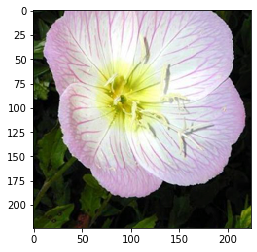

In [24]:
image = image_preprocessing('flowers/test/1/image_06743.jpg')
imshow(image)

# Class Prediction

In [25]:
probs, classes = predict('flowers/test/15/image_06369.jpg', model, training_imagefolder, 5)   
print(probs)
print(classes)

[0.9938846826553345, 0.00579900061711669, 0.00016869889805093408, 0.00012347089068498462, 2.1379877580329776e-05]
{'15', '83', '84', '42', '46'}


# Sanity Checking Utils

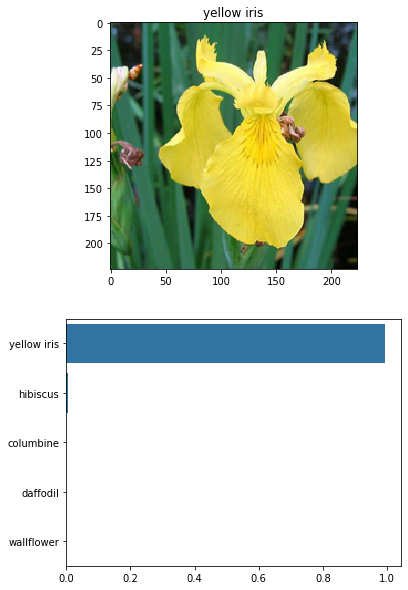

In [26]:
# Display an image along with the top 5 classes

# Plot flower input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = image_preprocessing('flowers/test/15/image_06369.jpg')

flower_title = flower_to_name['15']

imshow(image, plot_1, title=flower_title);

# Convert from the class integer encoding to actual flower names
flower_names = [flower_to_name[i] for i in classes]

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=flower_names, color=sb.color_palette()[0]);

plt.show()
